In [1]:
# Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
#                                        Ioanna Mitsioni
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os, errno
from random import shuffle
import numpy as np
from pylab import *
from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
import pywt
from scipy import signal
from scipy.signal import lfilter, butter
from numpy.fft import fft, fftfreq, rfft

# useful function for successful convertion from directories and lists to numpy arrays
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

# useful function for creating directory only if not existent
def ensure_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
h = .2  # step size in the mesh

######## TRAINING DEFAULTS
cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
classifiers = [KNeighborsClassifier(5),
               SVC(gamma='auto', C=1),
               MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]
parameters_clf = [{'n_neighbors':[4,7,9,12]},
                  {'kernel':['rbf'], 'C':[0.1,10,100,1000]},
                  {'solver':['lbfgs'], 'alpha':[1e-5,1e-2], 'hidden_layer_sizes':[(10,10),(50,50)]},
                  {'max_depth':[4,7,10,20],'n_estimators':[5,10,20],'max_features':[20,35,50]}]
makepipe_parameters_clf = [{'classifier__'+key:p[key] for key in p} for p in parameters_clf]
makepipe_parameters_clf += [{'feature_selection__k': (750,500,100), 'feature_selection__score_func': [mutual_info_classif]},
                            {'decomp__n_components': (100,50)}]

metric = ['accuracy','f1']
download = 1 # Download pre-computed (1) data or compute them all anew (0)

Automatically created module for IPython interactive environment


In [2]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift, keepfromshift = 1024, 20, 10
samplesperdataset = 10000
havelabel = 1
returntime = 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall,returntime]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep
######################################## Initialize necessary names and paths #####################################
datapath = 'tmp/'
ensure_dir(datapath)
datafile = datapath+'dataset.npz'
validfile = datapath+'validation.mat'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
ensure_dir(featpath)
prefeatid = [0,4]   # only the prefeatures with corresponding ids will be computed
prefeatname = 'prefeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'
featname = 'features'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
validfeatname = 'valid'+featname
validfeatfile = featpath+validfeatname+'.npz'
surffile = featpath+featname+'_2fing_6surf.npz'
XYfile = featpath+featname+'_XY.npz'
XYsplitfile = featpath+featname+'_XYsplit.npz'
validsurffile = featpath+featname+'_2fing_6surf_valid.npz'
validXYfile = featpath+featname+'_XY_valid.npz'
validXYsplitfile = featpath+featname+'_XYsplit_valid.npz'

In [3]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} -------------------> =  2+1.0samples ||           1026  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3107  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}

In [4]:
########################################## Download necessary files ################################################
# if download==1:
#     downpath = featpath
#     downfile = downpath+"features.tar.gz"
#     downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
#     if not os.path.isfile(downfile):
#         u = urllib.urlopen(downlink)
#         data = u.read()
#         print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
#         u.close()
#         with open(downfile, "wb") as f :
#             f.write(data)
#     else:
#         print 'Necessary ',downfile,'  already here!'
#     print 'Extracting files...'
#     directory = featpath
#     def extract_nonexisting(archive):
#         for name in archive.getnames():
#             if os.path.exists(os.path.join(directory, name)):
#                 print name, "already exists"
#             else:
#                 archive.extract(name, path=directory)
#     archives = [name for name in os.listdir(directory) if name.endswith("tar.gz")]
#     for archive_name in archives:
#         with tarfile.open(featpath+archive_name) as archive:
#             extract_nonexisting(archive)
# #     if (downfile.endswith("tar.gz")):
# #         tar = tarfile.open(downfile, "r:gz")
# #         tar.extractall(path=downpath)
# #         tar.close()
#     print 'Completed extracting files!'
########################################## Download necessary dataset #############################################
if not os.path.isfile(datafile):
#     downdata = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafile,'!'
#     u.close()
#     with open(datafile, "wb") as f :
#         f.write(data)
    print 'Necessary ',datafile,' not here! DO SOMETHING ABOUT IT!'
else:
    print 'Necessary ',datafile,' already here!'
if not os.path.isfile(validfile):
#     downdata = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafile,'!'
#     u.close()
#     with open(datafile, "wb") as f :
#         f.write(data)
    print 'Necessary ',validfile,' not here! DO SOMETHING ABOUT IT!'
else:
    print 'Necessary ',validfile,' already here!'

Necessary  tmp/dataset.npz  already here!
Necessary  tmp/validation.mat  already here!


In [5]:
########################################## READ THE DATASET #######################################################
# ################ DATASET, from each of the k fingers for all n surfaces (see fd for details) #############
def data_prep(datafile,step=1,k=2):
    print "----------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS -----------------------------"
    if datafile[-3:]=='mat':
        inp = sio.loadmat(datafile,struct_as_record=True)
    elif datafile[-3:]=='npz':
        inp = np.load(datafile)
    else:
        print "Unsupported input file format. Supported types: .npz .mat"
        return -1
    if k==2:
        f1, f2, l1, l2, fd1, fd2 = inp['f1'], inp['f2'], inp['l1'], inp['l2'], inp['fd1'], inp['fd2']
        print 1, '-> f1:', f1.shape, l1.shape, fd1.shape
        print 2, '-> f2:', f2.shape, l2.shape, fd2.shape
        ########################################### MERGE THE DATASETS ############################################
        f = np.concatenate((f1,f2),axis=0)
        l = np.concatenate((l1,l2),axis=0)
        fd = np.concatenate((fd2,fd2),axis=0)
    elif k==1:
        f, l, fd = inp['f'], inp['l'], inp['fd']
    else:
        print "Unsupported number of fingers k. Should be k in {1,2}"
    print 3, '-> f:', f.shape, l.shape, fd.shape
    # membership of each sample, representing its portion in the dataset (first half finger1 and second half finger2)
    member = np.zeros(len(f))
    m1,m2 = len(f)/2, len(f)/2
    member[:m1] = np.ones(m1)*1./m1
    member[-m2:] = np.ones(m2)*1./m2
    print 4, '-> m1,m2:', m1, m2, sum(member[:m1]), sum(member[-m2:])
    ########################################### MERGE f and l #####################################################
    while f.ndim>1:
        f = f[:,0]
        l = l[:,0]
    for i in range(len(f)):
        while l[i].ndim<2:
            l[i] = l[i][:,np.newaxis]
    f = np.array([np.concatenate((f[i],l[i]),axis=1) for i in range(len(f))])
    print 5, '-> f=f+l:', f.shape, ":", [fi.shape for fi in f]
    ########################################### SUBSAMPLING #######################################################
    # step = 1 # NO SAMPLING
    if step!=1:
        f = np.array([fi[::step,:] for fi in f])
        print 6, '-> fsampled:',f.shape, ":", [fi.shape for fi in f]
    return f,l,fd,member,m1,m2

In [6]:
###########################################################################################
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    # first normalize, then perform feature selection, followed by PCA and finally the desired classifier.
    pipeline = Pipeline([('scaler', scaler),
                         ('feature_selection', feature_selection),
                         ('decomp', decomp),         
                         ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    # first normalize, then perform feature selection, followed by PCA. 
    pipeline = Pipeline([('scaler', scaler),
                         ('feature_selection', feature_selection),
                         ('decomp', decomp) ])
    return pipeline

In [7]:
def gs_fun(clf,params,cv,x,y):
    grid_search = GridSearchCV(estimator=clf,param_grid= params, cv = cv, n_jobs=-1, verbose = 0)
    grid_search.fit(x,y)
    print("------ Grid search cv results for %0.8s ------" %clf)
    print("Best score: %0.4f" %grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
         print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters, grid_search.best_estimator_

In [8]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)

def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-2] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
############# PREFEATURE COMPUTATION
def compute_prefeat(f):
    print "---------------------------------------- COMPUTING PREFEATURES -----------------------------------------"
    prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
    prefeat = [np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))]
    prefeat.append(prefeat[-1][:-1])
    prefeat = np.array(prefeat)[:-1]
    print prefeat.shape,":",[p.shape for p in prefeat]
    return prefeat

In [9]:
############################# AVG Computation time of ALL features in secs ########################################
def avg_feat_comp_time(prefeat):
    print "------------------------------------- AVG FEATURE COMPUTATION TIME -------------------------------------"
    t1 = time.time()
    tmpfeat = [feat(prefeat[k][i:i+window,:2],*featparam) for k in range(20) for i in range(100)] # avg over 20*100 times
    print 'Avg feature computation time (millisec): ', (time.time()-t1)/(100*20)*1000

In [10]:
############################################# FEATURE COMPUTATION ##################################################
def tmpfeatfilename(p,name,mode='all'):
    allfeatpath = featpath+'AllFeatures/'
    ensure_dir(allfeatpath)
    if mode == 'all':
        return allfeatpath+name+str(p)+'.pkl.z'
    elif mode == 'red':
        return allfeatpath+name+str(p)+'_red'+str(samplesperdataset)+'.pkl.z'
    
# Computation of all features in parallel or loading if already computed
def feature_extraction(prefeat, member, featfile=featfile, name='feat_'):
    print "----------------------------------------- FEATURE EXTRACTION -------------------------------------------"
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp,name)
            tmpfnred = tmpfeatfilename(ixp,name,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in PARALLEL by ALL cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn, ' computing... ', tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn, ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                if tmpskip == 0: 
                    tmpskip = 1
                # Save reduced size features
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,name,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, 'already here!', tmp.shape
            features.append(tmp[:,:,:-1])
            labels.append(tmp[:,0,-1])
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        features.append(tmp[:-1,:,:-1])
        features = np.array(features)[:-1]
        labels.append(tmp[:-1,0,-1])
        labels = np.array(labels)[:-1]
        print 'features: ',features.shape,[ftmp.shape for ftmp in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        np.savez(featfile,features=features,labels=labels)
    print 'features: ', features.shape, ', labels: ', labels.shape
#     for i in range(features.shape[0]):
#         print i, np.array(features[i]).shape, np.array(labels[i]).shape
    return features, labels

In [11]:
###### Keeping the purely stable and slip parts of label, thus omitting some samples around sign change points 
def label_cleaning(prefeat,labels,member,history=500):
    print "------------ KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)------------"
    lbl_approx = []
    for i in range(len(prefeat)):
        tmpd = np.abs(np.diff(prefeat[i][:,-1].astype(int),n=1,axis=0))
        if np.sum(tmpd) > 0:
            tmpind = np.array(range(len(tmpd)))[tmpd > 0]   # find the sign change points
            tmpindrng = []
            for j in range(len(tmpind)):
                length = history                # keep/throw a portion of the signal's length around change points
                tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
                tmprng = tmprng[tmprng>=0]      # make sure inside singal's x-range
                tmprng = tmprng[tmprng<prefeat[i].shape[0]]
                tmpindrng += tmprng.tolist()
            tmpindrng = np.array(tmpindrng).flatten()
            tmp_lbl = deepcopy(prefeat[i][:,-1])
            tmp_lbl[tmpindrng] = -1
            lbl_approx.append(tmp_lbl)
        else:
            lbl_approx.append(prefeat[i][:,-1])
    # for i in range(len(lbl_approx)):
    #     print i, lbl_approx[i].shape, prefeat[i].shape

    new_labels = deepcopy(labels)
    for ixp in range(len(lbl_approx)):
        p = lbl_approx[ixp]
        tmp = np.array([p[k+window] for k in range(0,len(p)-window,shift)])
        tmpskip = int(round(tmp.shape[0]/(member[ixp]*samplesperdataset)))
        if tmpskip == 0: 
            tmpskip = 1
        # Sampling appropriately
        tmp = tmp[::tmpskip]
        if len(tmp) > len(labels[ixp]):
            tmp = tmp[:-1]
        new_labels[ixp] = tmp
    print 'new_labels: ', new_labels.shape
    return new_labels

In [12]:
########################## GATHERING into complete arrays ready for FITTING #######################################
def computeXY(features,labels,new_labels,m1,m2,XYfile=XYfile,XYsplitfile=XYsplitfile):
    print "------------------------------ COMPUTING X,Y for CLASSIFIERS' INPUT ------------------------------------"
    if os.path.isfile(XYfile) and os.path.isfile(XYsplitfile):
        X = np.load(XYfile)['X']
        Y = np.load(XYfile)['Y']
        Yn = np.load(XYfile)['Yn']
        Xsp = np.load(XYsplitfile)['X']
        Ysp = np.load(XYsplitfile)['Y']
        print("XY files FOUND PRECOMPUTED!")
    else:
        # gathering features X,Xsp and labels Y,Ysp,Yn into one array each
        ind,X,Xsp,Y,Ysp,Yn = {},{},{},{},{},{}
        ind[2] = range(features.shape[0])                                      # indeces for both fingers
        ind[0] = range(features.shape[0])[:m1]                                 # indeces for finger1
        ind[1] = range(features.shape[0])[-m2:]                                # indeces for finger2
        ind = np.array([i for _,i in ind.items()])                             # convert to array
        for k in range(len(ind)):
            X[k] = features[ind[k]]                                            # input feature matrix
            Y[k] = labels[ind[k]]                                              # output label vector
            Yn[k] = new_labels[ind[k]]                                         # output new_label vector
            print 'Before -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
            X[k] = np.concatenate(X[k],axis=0)
            Y[k] = np.concatenate(Y[k],axis=0)
            Yn[k] = np.concatenate(Yn[k],axis=0)
            print 'Gathered -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
            X[k] = np.array([X[k][:,:,i] for i in range(X[k].shape[2])])
            tmp_sampling = int(round(X[k].shape[1]*1./samplesperdataset))
            if tmp_sampling == 0:
                tmp_sampling = 1
            X[k] = X[k][0,::tmp_sampling,:]
            Y[k] = Y[k][::tmp_sampling]
            Yn[k] = Yn[k][::tmp_sampling]
            print 'Gathered, sampled to max ',samplesperdataset,' -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
            keepind = Yn[k]>=0
            Xsp[k] = X[k][keepind,:]
            Ysp[k] = Yn[k][keepind]
            print 'Split -> Xsp[',k,']: ',Xsp[k].shape,', Ysp[',k,']: ',Ysp[k].shape
        X = np.array([i for _,i in X.items()])
        Xsp = np.array([i for _,i in Xsp.items()])
        Y = np.array([i for _,i in Y.items()])
        Ysp = np.array([i for _,i in Ysp.items()])
        Yn = np.array([i for _,i in Yn.items()])
        np.savez(XYfile,X=X,Y=Y,Yn=Yn)
        np.savez(XYsplitfile, X=Xsp, Y=Ysp)
    print 'X,Y [0,1,2]: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape
    print 'Xsp,Ysp [0,1,2]: ', Xsp[0].shape, Ysp[0].shape, Xsp[1].shape, Ysp[1].shape, Xsp[2].shape, Ysp[2].shape
    return X,Y,Yn,Xsp,Ysp

In [13]:
# find the corresponding indeces of the desired features inside feature vector,
# and link them with their names and level of abstraction
def get_feat_id(feat_ind, printit=0, sample_window=window): 
    # get the feat inds wrt their source : 3rd level
    norm_time_phin = range(0,14)
    norm_freq_phin = range(norm_time_phin[-1] + 1, norm_time_phin[-1] + 9 + sample_window + 1)
    norm_time_golz = range(norm_freq_phin[-1] + 1, norm_freq_phin[-1] + 10 + sample_window + 1)
    norm_freq_golz = range(norm_time_golz[-1] + 1, norm_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    norm_time_feats = norm_time_phin + norm_time_golz
    norm_freq_feats = norm_freq_phin + norm_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    norm_feats = norm_time_feats + norm_freq_feats

    # get the feat inds wrt their source : 3rd level
    disp = norm_feats[-1]+1
    ftfn_time_phin = range(disp ,disp + 14)
    ftfn_freq_phin = range(ftfn_time_phin[-1] + 1, ftfn_time_phin[-1] + 9 + sample_window + 1)
    ftfn_time_golz = range(ftfn_freq_phin[-1] + 1, ftfn_freq_phin[-1] + 10 + sample_window + 1)
    ftfn_freq_golz = range(ftfn_time_golz[-1] + 1, ftfn_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    ftfn_time_feats = ftfn_time_phin + ftfn_time_golz
    ftfn_freq_feats = ftfn_freq_phin + ftfn_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    ftfn_feats = ftfn_time_feats + ftfn_freq_feats

    # create the final "reference dictionary"
    id_list = [np.zeros((len(ftfn_feats + norm_feats),1)) for i in range(3)] #3 np.arrays, id_list[0] = level 1 etc
    id_list[0][:norm_feats[-1]+1] = 0 # 0 signifies norm / 1 signifies ft/fn
    id_list[0][norm_feats[-1]+1:] = 1

    id_list[1][:norm_time_phin[-1]+1] = 0 #0 signifies time / 1 signifies freq
    id_list[1][norm_time_phin[-1]+1:norm_freq_phin[-1]+1] = 1
    id_list[1][norm_freq_phin[-1]+1:norm_time_golz[-1]+1] = 0
    id_list[1][norm_time_golz[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[1][norm_freq_golz[-1]+1:ftfn_time_phin[-1]+1] = 0
    id_list[1][ftfn_time_phin[-1]+1:ftfn_freq_phin[-1]+1] = 1
    id_list[1][ftfn_freq_phin[-1]+1:ftfn_time_golz[-1]+1] = 0
    id_list[1][ftfn_time_golz[-1]+1:] = 1

    id_list[2][:norm_freq_phin[-1]+1] = 0 #0 signifies phinyomark / 1 signifies golz
    id_list[2][norm_freq_phin[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[2][norm_freq_golz[-1]+1:ftfn_freq_phin[-1]+1] = 0
    id_list[2][ftfn_freq_phin[-1]+1:] = 1 
    
    full_path_id = [np.zeros((len(feat_ind),5)) for i in range(len(feat_ind))]
   
    for ind, val in enumerate(feat_ind):
        full_path_id[ind] = [val, id_list[2][val], id_list[1][val], id_list[0][val]]
        if (printit==1):
            if(full_path_id[ind][1]==0):
                lvl3 = 'Phin'
            else:
                lvl3 = 'Golz'
            if(full_path_id[ind][2]==0):
                lvl2 = 'Time'
            else:
                lvl2 = 'Freq'
            if(full_path_id[ind][3]==0):
                lvl1 = 'Norm'
            else:
                lvl1 = 'Ft/Fn'
            print(feat_ind[ind],featnames[val%(norm_feats[-1]+1)],lvl3,lvl2,lvl1)
    
    return(full_path_id,norm_time_feats,norm_freq_feats)        

In [14]:
def get_feat_occ(feat_masks):
    #get the number of occurences for each feature after SelectKbest
    feat_occ = Counter(feat_masks)
    return feat_occ 

In [15]:
# Split input data in k*n equal slices which represent n different surfaces sampled from k fingers
def surface_split(data_X, data_Y, n=6, k=2):
    # n different surfaces, with the convention that data_X contains k*n almost equally sized data
    # where the n first are acquired from finger1 ... and the n last from fingerk. 
    # step of n: 0 upto (k-1)*n, 1 upto (k-1)*n+1, 2 upto (k-1)*n+2, ... correspond to the same surface (finger1 upto fingerk)
    # assuming k=2, namely 2 fingers case, unless stated differently
    keep = data_X.shape[0]-np.mod(data_X.shape[0],k*n)
    surfaces_pre = np.array(np.split(data_X[:keep,:],k*n))
    surf_labels_pre = np.array(np.split(data_Y[:keep],k*n))
    surfaces, surf_labels = {},{}
    for i in range(n):
        inds = range(i,k*n,n)
        surfaces[inds[0]] = np.concatenate((surfaces_pre[inds[0]], surfaces_pre[inds[1]]), axis = 0)
        surf_labels[inds[0]] = np.concatenate((surf_labels_pre[inds[0]], surf_labels_pre[inds[1]]), axis = 0)
    surfaces = np.array([i for _,i in surfaces.items()])
    surf_labels = np.array([i for _,i in surf_labels.items()])
    return surfaces, surf_labels

In [16]:
def feat_subsets(data,fs_ind,ofs=len(featnames)):
    _,tf,ff = get_feat_id(range(ofs))
    amfft_inds = []
    temp1 = deepcopy(data)
    
    for i in range(len(featnames)):
        if (featnames[i].startswith('amFFT')):
            amfft_inds.append(i)

    if (fs_ind == 2):
        ff2 = [ff[i]+ofs for i in range(len(ff))]
        tf2 = [tf[i]+ofs for i in range(len(tf))]
        amfft2 = [amfft_inds[i]+ofs for i in range(len(amfft_inds))]
        freqf = ff2 + ff
        timef = tf2 + tf
        amfft = amfft_inds + amfft2
    else:
        freqf = ff
        timef = tf
        amfft = amfft_inds

    X_amfft = temp1[:,amfft]
    X_time = np.delete(temp1,freqf,axis=1)
    X_freq_all = np.delete(temp1,timef,axis=1)
    X_both = data
    return X_amfft, X_freq_all, X_time, X_both

In [17]:
################################## Prepare the dataset split for each surface ######################################
def computeXY_persurf(Xsp,Ysp,surffile=surffile):
    print "------------------------- COMPUTING X,Y per surface CLASSIFIERS' INPUT ---------------------------------"
    if os.path.isfile(surffile):
        surf = np.load(surffile)['surf']       # input array containing computed features for each surface
        surfla = np.load(surffile)['surfla']   # corresponding label
    else:
        surf, surfla = [], []
        for i in range(len(prefeatid)-1): # for each featureset (corresponding to each prefeature, here only |f|)
            surf1, surfla1 = surface_split(Xsp[2], Ysp[2])
            tmpsurf = deepcopy(surf1)
            tmpsurfla = deepcopy(surfla1)
            tmpsurfsubfeat = []
            for j in range(tmpsurf.shape[0]+1): # for each surface
                print i,j,surf1.shape
                if j == tmpsurf.shape[0]:
                    tmpsurfsubfeat.append(feat_subsets(tmpsurf[j-1,:-1,:],i)) # ommit a sample for converting to array
                else:
                    tmpsurfsubfeat.append(feat_subsets(tmpsurf[j],i)) # keep all subfeaturesets
            surf.append(tmpsurfsubfeat)
            surfla.append(surfla1)
        # surf dims: (featuresets, surfaces, prefeaturesets) with each one enclosing (samples, features)
        surf = np.array(surf).transpose()[:,:-1,:]
        # surfla dims: (samples, surfaces, prefeaturesets)
        surfla = np.array(surfla).transpose()
        np.savez(surffile,surf=surf,surfla=surfla)
    print surf.shape, surfla.shape
    return surf, surfla

In [18]:
######## Cross surface validation, TRAINING with 1 surface each time, out of 6 surfaces in total
##### total: 4 (featuresets) * [comb(6,1)*6] (surface combinations: trained on 1 - tested on 1) * 1 (prefeatureset)
##### = 4*6*6*1 = 144 different runs-files.
##### note that comb(n,r) = n!/(r!(n-r)!)
def filename1(i,j,k,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr_'+str(k)+'_ts_'+str(l)

def cross_fit1(i,j,k,kmax,l,data,labels,data2,labels2,pipe):
    filepath = datapath+'/results1/'
    ensure_dir(filepath)
    fileid = filepath+filename1(i,j,k,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k,l
        if k==l: # perform K-fold cross-validation       
            folds = cv.split(data, labels)
            cm_all = np.zeros((2,2))
            for fold, (train_ind, test_ind) in enumerate(folds):
                x_train, x_test = data[train_ind], data[test_ind]
                y_train, y_test = labels[train_ind], labels[test_ind]
                model = pipe.fit(x_train,y_train)
                y_pred = model.predict(x_test)
                cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_all += cm/5.
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            # Check if model already existent, but not the cross-validated one (on the same surface)
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename1(i,j,k,m)+'.npz'
                if k!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps1(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k in range(surf.shape[0]): # for every training surface
        for l in range(surf.shape[0]): # for every testing surface
            cross_fit1(i,j,k,surf.shape[0],l,surf[k],surfla[:,k],surf[l],surfla[:,l],pipe)

def train_1_surface(surf,surfla,n=-1):
    print "--------------------------- TRAINING all combinations per 1 surface ------------------------------------"
    ##### Parallelized -on surface level- training of models with 1 surface
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps1) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                  for j in range(surf.shape[0])])]            

In [19]:
######## Cross surface validation, training with 2 surfaces each time, out of 6 surfaces in total
##### total: 4 (featuresets) * [comb(6,2)*6] (surface combinations: trained on 2 - tested on 1) * 1 (prefeatureset)
##### = 4*15*6*1 = 360 different runs-files.
##### note that comb(n,r) = n!/(r!(n-r)!)
def filename2(i,j,k1,k2,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_ts_'+str(l)

def cross_fit2(i,j,k1,k2,kmax,l,data,labels,data2,labels2,pipe):
    filepath = datapath+'/results2/'
    ensure_dir(filepath)
    fileid = filepath+filename2(i,j,k1,k2,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,l
        if k1==l or k2==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,k2)+'.npz'
            else:   # same as above
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,k1)+'.npz'                
            if not os.path.isfile(tmpcopyfileid):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                cm_all = np.load(tmpcopyfileid)['cm']
                model = np.load(tmpcopyfileid)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename2(i,j,k1,k2,m)+'.npz'
                if k1!=m and k2!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps2(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for l in range(surf.shape[0]): # for every testing surface
                    tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2]),axis=0)
                    ts_surf, ts_surfla = surf[l], surfla[:,l]
                    cross_fit2(i,j,k1,k2,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_2_surface(surf,surfla,n=-1):
    print "--------------------------- TRAINING all combinations per 2 surfaces -----------------------------------"    
    ##### Parallelized -on surface level- training of models with 2 surfaces
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps2) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]

In [20]:
######## Cross surface validation, training with 3 surfaces each time, out of 6 surfaces in total
##### total: 4 (featuresets) * [comb(6,3)*6] (surface combinations: trained on 3 - tested on 1) * 1 (prefeatureset)
##### = 4*20*6*1 = 480 different runs-files.
##### note that comb(n,r) = n!/(r!(n-r)!)
def filename3(i,j,k1,k2,k3,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_ts_'+str(l)

def cross_fit3(i,j,k1,k2,k3,kmax,l,data,labels,data2,labels2,pipe):
    filepath = datapath+'/results3/'
    ensure_dir(filepath)
    fileid = filepath+filename3(i,j,k1,k2,k3,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,l
        if k1==l or k2==l or k3==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k3)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k3)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename3(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename3(i,j,k1,k2,k3,k2)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                else:
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename3(i,j,k1,k2,k3,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps3(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for l in range(surf.shape[0]): # for every testing surface
                            tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                            cross_fit3(i,j,k1,k2,k3,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_3_surface(surf,surfla,n=-1):
    print "--------------------------- TRAINING all combinations per 3 surfaces -----------------------------------"
    ##### Parallelized -on surface level- training of models with 3 surfaces
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps3) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]

In [21]:
######## Cross surface validation, training with 4 surfaces each time, out of 6 surfaces in total
##### total: 4 (featuresets) * [comb(6,4)*6] (surface combinations: trained on 4 - tested on 1) * 1 (prefeatureset)
##### = 4*15*6*1 = 360 different runs-files.
##### note that comb(n,r) = n!/(r!(n-r)!)
def filename4(i,j,k1,k2,k3,k4,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_tr4_'+str(k4)+'_ts_'+str(l)

def cross_fit4(i,j,k1,k2,k3,k4,kmax,l,data,labels,data2,labels2,pipe):
    filepath = datapath+'/results4/'
    ensure_dir(filepath)
    fileid = filepath+filename4(i,j,k1,k2,k3,k4,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,l
        if k1==l or k2==l or k3==l or k4==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k4)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename4(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename4(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename4(i,j,k1,k2,k3,k4,k3)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) and not os.path.isfile(tmpcopyfileid3):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename4(i,j,k1,k2,k3,k4,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and k4!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+str(k4)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps4(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for l in range(surf.shape[0]): # for every testing surface
                                    tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                                    ts_surf, ts_surfla = surf[l], surfla[:,l]
                                    cross_fit4(i,j,k1,k2,k3,k4,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_4_surface(surf,surfla,n=-1):
    print "--------------------------- TRAINING all combinations per 4 surfaces -----------------------------------"        
    ##### Parallelized -on surface level- training of models with 4 surfaces                    
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps4) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]

In [22]:
######## Cross surface validation, training with 5 surfaces each time, out of 6 surfaces in total
##### total: 4 (featuresets) * [comb(6,5)*6] (surface combinations: trained on 5 - tested on 1) * 1 (prefeatureset)
##### = 4*6*6*1 = 144 different runs-files.
##### note that comb(n,r) = n!/(r!(n-r)!)
def filename5(i,j,k1,k2,k3,k4,k5,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_tr4_'+str(k4)+'_tr5_'+str(k5)+'_ts_'+str(l)

def cross_fit5(i,j,k1,k2,k3,k4,k5,kmax,l,data,labels,data2,labels2,pipe):
    filepath = datapath+'/results5/'
    ensure_dir(filepath)
    fileid = filepath+filename5(i,j,k1,k2,k3,k4,k5,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,k5,l
        if k1==l or k2==l or k3==l or k4==l or k5==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-"+str(k5)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k4:   # same as above
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            else:
                tmpcopyfileid1 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = filepath+filename5(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) and not os.path.isfile(tmpcopyfileid3) and not os.path.isfile(tmpcopyfileid4):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
                elif os.path.isfile(tmpcopyfileid4):
                    cm_all = np.load(tmpcopyfileid4)['cm']
                    model = np.load(tmpcopyfileid4)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            model = []
            for m in range(kmax):
                tmpcopyfileid = filepath+filename5(i,j,k1,k2,k3,k4,k5,m)+'.npz'
                if k1!=m and k2!=m and k3!=m and k4!=m and k5!=m and os.path.isfile(tmpcopyfileid):
                    print 'Found precomputed model of '+str(k1)+str(k2)+str(k3)+str(k4)+str(k5)+', tested on '+str(m)+'. Testing on '+str(l)+'...'
                    model = np.load(tmpcopyfileid)['model'][0]
                    break
            if model==[]: # model not found precomputed
                print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-"+str(k5)+', testing on '+str(l)+'...'
                model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps5(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for k5 in range(surf.shape[0]):
                                    if k5 > k4:
                                        for l in range(surf.shape[0]): # for every testing surface
                                            tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                                            cross_fit5(i,j,k1,k2,k3,k4,k5,surf.shape[0],l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

def train_5_surface(surf,surfla,n=-1):
    print "--------------------------- TRAINING all combinations per 5 surfaces -----------------------------------"        
    ##### Parallelized -on surface level- training of models with 5 surfaces
    for i in range(len(prefeatid)-1):
        _ = [Parallel(n_jobs=n)([delayed(init_steps5) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) 
                                 for j in range(surf.shape[0])])]

In [23]:
############################################## TRAINING PROCEDURE #################################################
f,l,fd,member,m1,m2 = data_prep(datafile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member)
avg_feat_comp_time(prefeat)
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2)
surf, surfla = computeXY_persurf(Xsp,Ysp)
train_1_surface(surf,surfla)
train_2_surface(surf,surfla)
train_3_surface(surf,surfla)
train_4_surface(surf,surfla)
train_5_surface(surf,surfla)

----------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS -----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), 

In [24]:
############################################## TESTING PROCEDURE ##################################################
f,l,fd,member,m1,m2 = data_prep(validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,validXYfile,validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,validsurffile)

----------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS -----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
---------------------------------------- COMPUTING PREFEATURES -----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
----------------------------------------- FEATURE EXTRACTION -------------------------------------------
Features FOUND PRECOMPUTED! Feature Loading DONE in: 0.503178119659 seconds 
features:  (2,) , labels:  (2,)
------------ KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS (TRIMMING AROUND CHANGE POINTS)------------
new_labels:  (2,)
------------------------------ COMPUTING X,Y for CLASSIFIERS' INPUT ------------------------------------
XY files FOUND PRECOMPUTED!
X,Y [0,1,2]:  (3199, 3107) (3199,) (3199, 3107) (3199,) (6398, 3107) (6398,)
Xsp,Ysp [0,1,2]:  (2769, 3107) (2769,) (2769,

(2769,) (2769,) (2769,)


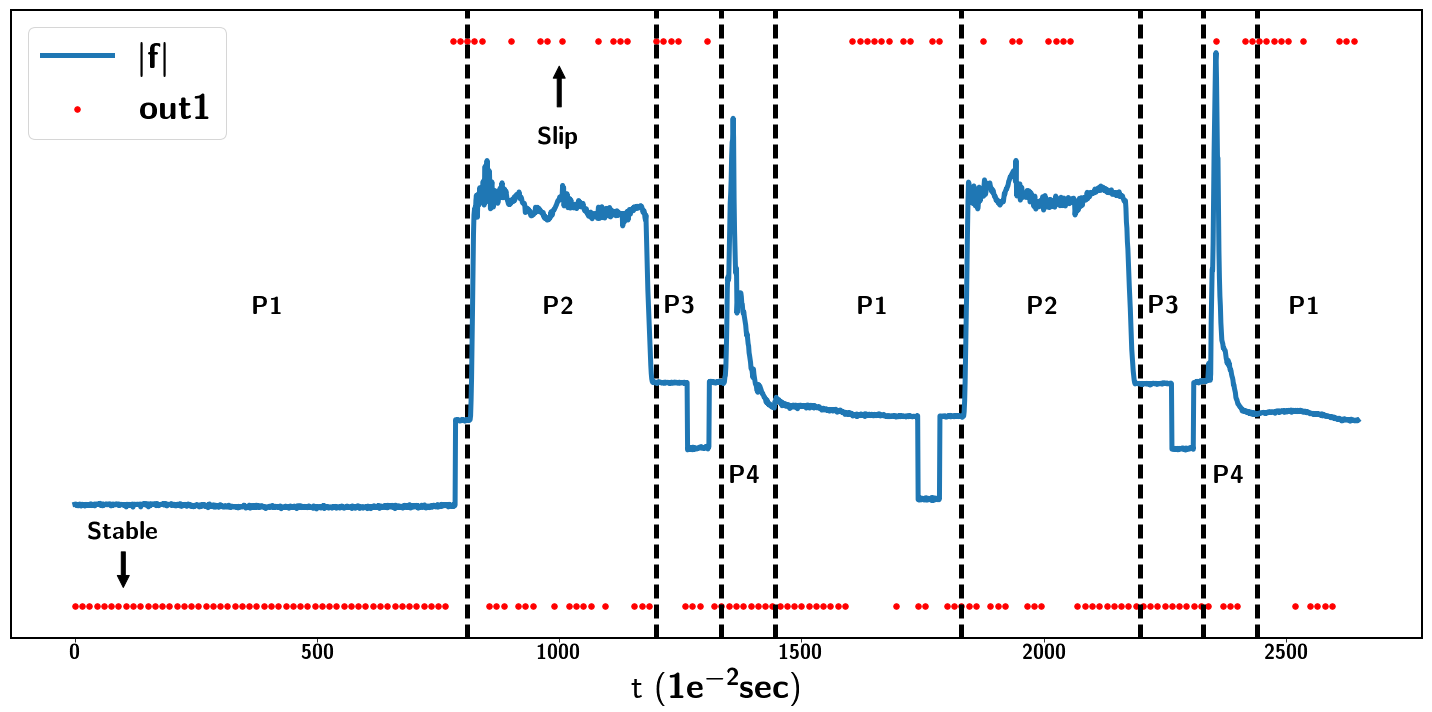

In [47]:
subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = datapath+'results1/'+filename1(0,3,0,5)+'.npz'
fileidb = datapath+'results1/'+filename1(0,0,0,5)+'.npz'
fileid5 = datapath+'results5/'+filename5(0,3,0,1,2,3,4,5)+'.npz'
fileid5b = datapath+'results5/'+filename5(0,0,0,1,2,3,4,5)+'.npz'
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(Xsp[0])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
ax = plt.figure(figsize=(20,10))
p = plt.scatter(range(len(Yout[50:2700]))[::15],Yout[50:2700][::15]+0.02,color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)

tf = np.linalg.norm(f[0][2000::20][:2650],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig('validation.pdf', bbox_inches='tight')
